# Data Preprocessing


Importing Libraries

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision import datasets, transforms, models

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm


Data Configuration

In [ ]:
data_dir = '/kaggle/input/face-classification-deep-learning-cs-405/dataset'  # Replace with your actual path
val_ratio = 0.1
test_ratio = 0.1
batch_size = 64
image_size = 224


Data Augmentation and Preprocessing

In [ ]:
# Data transformations for training set
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),          # Resize images to a fixed size
    transforms.RandomHorizontalFlip(),                    # Randomly flip images horizontally
    transforms.RandomRotation(10),                        # Randomly rotate images by ±10 degrees
    transforms.ToTensor(),                                # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406],            # Normalize using ImageNet mean
                         [0.229, 0.224, 0.225])            # and standard deviation
])

# Data transformations for validation and test sets (no augmentations)
eval_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),          # Resize images to the same size as training
    transforms.ToTensor(),                                # Convert to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406],            # Normalize using ImageNet statistics
                         [0.229, 0.224, 0.225])
])


Load Full Dataset and Extract Class Information

In [ ]:
# Load the full training dataset using the defined training transformations
full_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'),
                                    transform=train_transform)

# Get the list of class names (folder names inside the dataset)
class_names = full_dataset.classes

# Get the total number of images in the dataset
total_len = len(full_dataset)
print(f"Total images: {total_len}")  # Print total image count for reference


Total images: 140000


Split Dataset into Train, Validation, and Test Sets

In [ ]:
# Calculate the number of samples for validation and test sets
val_len = int(total_len * val_ratio)
test_len = int(total_len * test_ratio)

# Remaining samples will be used for training
train_len = total_len - val_len - test_len

# Randomly split the full dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_len, val_len, test_len]
)


Apply Evaluation Transforms to Validation and Test Sets

In [ ]:
# Override the transform for validation set with evaluation (non-augmented) transforms
val_dataset.dataset.transform = eval_transform

# Override the transform for test set with evaluation (non-augmented) transforms
test_dataset.dataset.transform = eval_transform


Create DataLoaders for Training, Validation, and Testing

In [ ]:
# DataLoader for training data (shuffling enabled for better generalization)
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=4, pin_memory=True)

# DataLoader for validation data (no shuffling to maintain consistency)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=4, pin_memory=True)

# DataLoader for test data (no shuffling, just like validation)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=4, pin_memory=True)


Dataset Summary Output

In [ ]:
# Print dataset split information and number of classes
print(f"[INFO] Train: {train_len}, Val: {val_len}, Test: {test_len}, Classes: {len(class_names)}")


[INFO] Train: 112000, Val: 14000, Test: 14000, Classes: 7000


# Model no. 1: Mobilenet_v2

Model Setup and Configuration

In [ ]:
# Set the number of output classes based on the dataset
num_classes = len(class_names)

# Load the pretrained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Modify the classifier to match the number of classes in your dataset
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Move the model to GPU if available (else use CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print the model architecture summary to verify the changes
print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 169MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Optimizer, Loss Function, and Training Loop Setup

In [ ]:
# Initialize the optimizer using Adam with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function as Cross-Entropy Loss (suitable for classification tasks)
criterion = nn.CrossEntropyLoss()

# Set the number of epochs for training
num_epochs = 20


Checkpoint Saving Function

In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, path="checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),  # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state
        'loss': loss  # Save the loss for the current epoch
    }, path)

Training Loop with Metrics and Checkpoint Saving



In [ ]:
# Initialize lists to store metrics for visualization
train_losses = []
train_top1_accs = []
train_top5_accs = []
val_losses = []
val_top1_accs = []
val_top5_accs = []

# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    # Progress bar for training set
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Optimizer step

        running_loss += loss.item()  # Accumulate the loss
        total += labels.size(0)  # Accumulate the number of samples

        # Top-1 Accuracy
        _, top1_preds = torch.max(outputs, 1)
        correct_top1 += (top1_preds == labels).sum().item()

        # Top-5 Accuracy
        _, top5_preds = outputs.topk(5, dim=1)
        correct_top5 += top5_preds.eq(labels.view(-1, 1).expand_as(top5_preds)).any(dim=1).sum().item()

        # Update progress bar with current loss and accuracies
        train_loader_tqdm.set_postfix(loss=loss.item(),
                                      top1=100 * correct_top1 / total,
                                      top5=100 * correct_top5 / total)

    # Validation Phase (no gradient updates)
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct_top1 = 0
    val_correct_top5 = 0
    val_total = 0

    with torch.no_grad():  # Disable gradient tracking for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            val_loss += loss.item()  # Accumulate validation loss
            val_total += labels.size(0)  # Accumulate validation samples

            # Top-1 Accuracy (Validation)
            _, val_top1_preds = torch.max(outputs, 1)
            val_correct_top1 += (val_top1_preds == labels).sum().item()

            # Top-5 Accuracy (Validation)
            _, val_top5_preds = outputs.topk(5, dim=1)
            val_correct_top5 += val_top5_preds.eq(labels.view(-1, 1).expand_as(val_top5_preds)).any(dim=1).sum().item()

    # Epoch Summary
    avg_train_loss = running_loss / len(train_loader)  # Average training loss
    train_top1_acc = 100 * correct_top1 / total  # Top-1 training accuracy
    train_top5_acc = 100 * correct_top5 / total  # Top-5 training accuracy
    avg_val_loss = val_loss / len(val_loader)  # Average validation loss
    val_top1_acc = 100 * val_correct_top1 / val_total  # Top-1 validation accuracy
    val_top5_acc = 100 * val_correct_top5 / val_total  # Top-5 validation accuracy

    # Store metrics for visualization
    train_losses.append(avg_train_loss)
    train_top1_accs.append(train_top1_acc)
    train_top5_accs.append(train_top5_acc)
    val_losses.append(avg_val_loss)
    val_top1_accs.append(val_top1_acc)
    val_top5_accs.append(val_top5_acc)

    # Print epoch summary
    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {avg_train_loss:.4f} | Top-1 Acc: {train_top1_acc:.2f}% | Top-5 Acc: {train_top5_acc:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} | Top-1 Acc: {val_top1_acc:.2f}% | Top-5 Acc: {val_top5_acc:.2f}%")

    # Save checkpoint after each epoch
    checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
    save_checkpoint(model, optimizer, epoch+1, avg_val_loss, checkpoint_path)
    print(f"[INFO] Checkpoint saved at {checkpoint_path}")


[Epoch 1] Train Loss: 7.9830 | Top-1 Acc: 0.12% | Top-5 Acc: 0.59% || Val Loss: 7.4652 | Top-1 Acc: 0.34% | Top-5 Acc: 1.54%
[INFO] Checkpoint saved at checkpoint_epoch_1.pth


[Epoch 2] Train Loss: 6.9869 | Top-1 Acc: 0.85% | Top-5 Acc: 3.47% || Val Loss: 6.5300 | Top-1 Acc: 2.10% | Top-5 Acc: 7.51%
[INFO] Checkpoint saved at checkpoint_epoch_2.pth


[Epoch 3] Train Loss: 6.0501 | Top-1 Acc: 3.60% | Top-5 Acc: 11.68% || Val Loss: 5.7425 | Top-1 Acc: 6.26% | Top-5 Acc: 17.94%
[INFO] Checkpoint saved at checkpoint_epoch_3.pth


[Epoch 6] Train Loss: 3.9081 | Top-1 Acc: 24.49% | Top-5 Acc: 47.53% || Val Loss: 4.3496 | Top-1 Acc: 22.68% | Top-5 Acc: 42.89%
[INFO] Checkpoint saved at checkpoint_epoch_6.pth


[Epoch 7] Train Loss: 3.4068 | Top-1 Acc: 32.30% | Top-5 Acc: 56.19% || Val Loss: 3.9525 | Top-1 Acc: 28.97% | Top-5 Acc: 50.15%
[INFO] Checkpoint saved at checkpoint_epoch_7.pth


[Epoch 9] Train Loss: 2.6116 | Top-1 Acc: 45.93% | Top-5 Acc: 69.39% || Val Loss: 3.4818 | Top-1 Acc: 36.54% | Top-5 Acc: 57.69%
[INFO] Checkpoint saved at checkpoint_epoch_9.pth


[Epoch 10] Train Loss: 2.2856 | Top-1 Acc: 51.61% | Top-5 Acc: 74.10% || Val Loss: 3.4195 | Top-1 Acc: 39.97% | Top-5 Acc: 60.69%
[INFO] Checkpoint saved at checkpoint_epoch_10.pth


[Epoch 11] Train Loss: 2.0170 | Top-1 Acc: 56.76% | Top-5 Acc: 78.13% || Val Loss: 3.3652 | Top-1 Acc: 40.73% | Top-5 Acc: 61.23%
[INFO] Checkpoint saved at checkpoint_epoch_11.pth


[Epoch 12] Train Loss: 1.7866 | Top-1 Acc: 61.10% | Top-5 Acc: 81.27% || Val Loss: 3.1446 | Top-1 Acc: 44.27% | Top-5 Acc: 64.68%
[INFO] Checkpoint saved at checkpoint_epoch_12.pth


[Epoch 14] Train Loss: 1.4027 | Top-1 Acc: 68.45% | Top-5 Acc: 86.40% || Val Loss: 3.1032 | Top-1 Acc: 47.59% | Top-5 Acc: 67.45%
[INFO] Checkpoint saved at checkpoint_epoch_14.pth


[Epoch 15] Train Loss: 1.2475 | Top-1 Acc: 71.55% | Top-5 Acc: 88.31% || Val Loss: 3.0002 | Top-1 Acc: 48.48% | Top-5 Acc: 68.21%
[INFO] Checkpoint saved at checkpoint_epoch_15.pth


[Epoch 16] Train Loss: 1.1088 | Top-1 Acc: 74.61% | Top-5 Acc: 89.96% || Val Loss: 3.0951 | Top-1 Acc: 48.81% | Top-5 Acc: 68.59%
[INFO] Checkpoint saved at checkpoint_epoch_16.pth


[Epoch 17] Train Loss: 0.9918 | Top-1 Acc: 76.86% | Top-5 Acc: 91.29% || Val Loss: 3.1014 | Top-1 Acc: 49.93% | Top-5 Acc: 68.88%
[INFO] Checkpoint saved at checkpoint_epoch_17.pth


[Epoch 18] Train Loss: 0.8863 | Top-1 Acc: 79.00% | Top-5 Acc: 92.44% || Val Loss: 3.1071 | Top-1 Acc: 50.95% | Top-5 Acc: 70.09%
[INFO] Checkpoint saved at checkpoint_epoch_18.pth


Epoch 19/20:  27%|██▋       | 475/1750 [01:55<05:09,  4.12it/s, loss=0.692, top1=83, top5=94.3]  

Loss Over Epochs Visualization

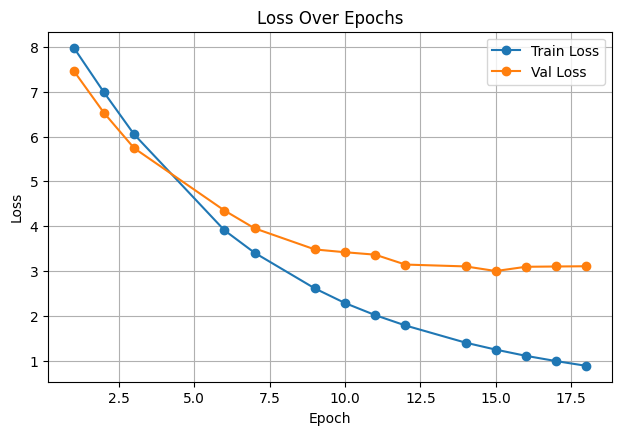

In [2]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Top-1 Accuracy Over Epochs Visualization

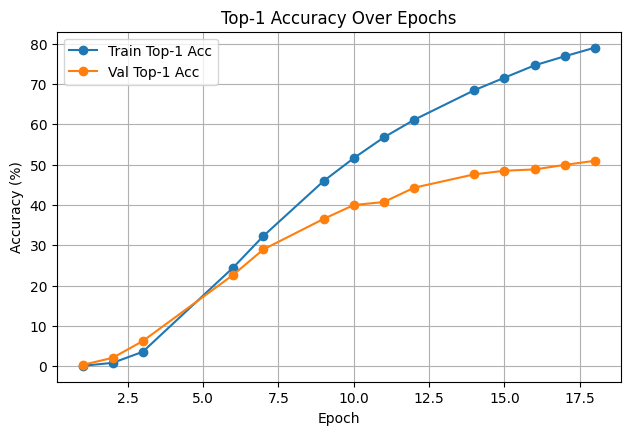

In [5]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 2)
plt.plot(epochs, train_top1, label='Train Top-1 Acc', marker='o')
plt.plot(epochs, val_top1, label='Val Top-1 Acc', marker='o')
plt.title('Top-1 Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()
plt.show()

Top-5 Accuracy Over Epochs Visualization

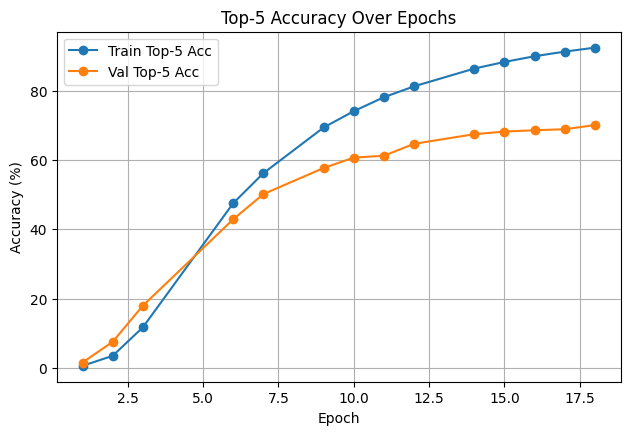

In [6]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 3)
plt.plot(epochs, train_top5, label='Train Top-5 Acc', marker='o')
plt.plot(epochs, val_top5, label='Val Top-5 Acc', marker='o')
plt.title('Top-5 Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

Highlighting Potential Overfitting (Top-1 Accuracy Gap)

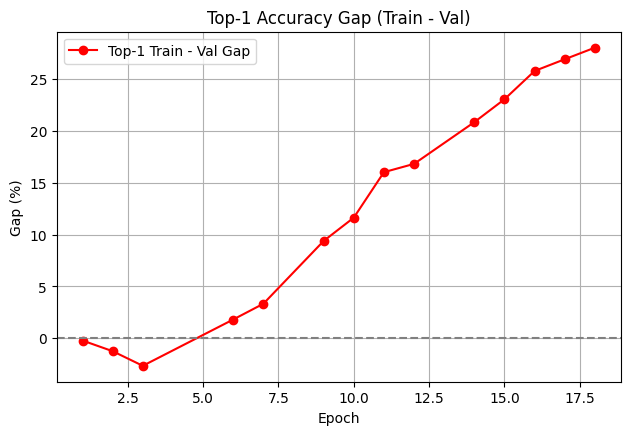

In [7]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 4)
gap = [tr - va for tr, va in zip(train_top1, val_top1)]
plt.plot(epochs, gap, label='Top-1 Train - Val Gap', color='red', marker='o')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Top-1 Accuracy Gap (Train - Val)')
plt.xlabel('Epoch')
plt.ylabel('Gap (%)')
plt.legend()
plt.grid(True)
plt.show()

Model Evaluation on Test Set

In [8]:
# Define the evaluate function to calculate accuracy on a given data loader (test or validation)
def evaluate(model, data_loader):
    # Set the model to evaluation mode
    model.eval()
    correct = 0
    total = 0

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for inputs, labels in data_loader:
            # Move inputs and labels to the appropriate device (e.g., GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Perform the forward pass
            outputs = model(inputs)

            # Get predicted class labels (with the highest probability)
            _, predicted = torch.max(outputs, 1)

            # Update the total number of samples and the number of correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy as percentage
    return 100 * correct / total

# Evaluate the model on the test dataset and print the accuracy
test_accuracy = evaluate(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 76.78%


To use model for inference after training

Load Model Checkpoint

In [ ]:
checkpoint_path = '/kaggle/input/firstmodel/checkpoint_epoch_15.pth'
checkpoint = torch.load(checkpoint_path)

/tmp/ipykernel_31/2074209506.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loading Optimizer and loss function

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


Restoring Model and Optimizer from Checkpoint

In [ ]:
# Restore the model state from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])  # Load the model's learned weights from the checkpoint

# If you want to restore the optimizer's state (e.g., to continue training from where it left off)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # Load the optimizer's state (momentum, learning rate, etc.)


Retrieve and Print Epoch and Loss Information

In [ ]:
# Optionally, retrieve epoch and loss information from the checkpoint if needed
epoch = checkpoint['epoch']  # Retrieve the epoch number when the checkpoint was saved
loss = checkpoint['loss']  # Retrieve the loss value at the time of saving the checkpoint

# Print the information to confirm which epoch and loss were loaded from the checkpoint
print(f"Model loaded from epoch {epoch} with validation loss {loss:.4f}")


Model loaded from epoch 15 with validation loss 3.0002


In [ ]:
import os
from PIL import Image
import pandas as pd
from torchvision import transforms
import torch
from tqdm import tqdm

# Path to test images
test_dir = os.path.join(data_dir, 'test')
test_image_names = sorted(os.listdir(test_dir))

# Set model to eval mode
model.eval()

# Apply same eval transforms used during validation
transform = eval_transform

# Store predictions
image_ids = []
predicted_labels = []

with torch.no_grad():
    for img_name in tqdm(test_image_names, desc="Predicting"):
        img_path = os.path.join(test_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        label = class_names[predicted.item()]

        image_ids.append(img_name)
        predicted_labels.append(label)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'image_name': image_ids,
    'label': predicted_labels
})

# Save to CSV
submission_df.to_csv('submission.csv', index=False)
print("[INFO] submission.csv has been saved.")


Predicting: 100%|██████████| 35000/35000 [09:34<00:00, 60.96it/s]

[INFO] submission.csv has been saved.


### Experiment with different combinations

Model Configuration Setup

In [ ]:
# ==== Configurations ====

# Number of classes based on the dataset's class names
num_classes = len(class_names)  # Set the number of output classes to the number of classes in your dataset

# Total number of epochs for training
num_epochs = 25  # The number of times the entire dataset will be passed through the model

# Patience for Early Stopping
patience = 3

# Batch size used during training
batch_size = 32  # The number of training examples used in one forward/backward pass

# Learning rate for the optimizer
learning_rate = 0.01  # Defines the step size in updating model weights

# Dropout rate for regularization to prevent overfitting
dropout_rate = 0.5  # 50% dropout rate in fully connected layers

# Setting up the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Choose device for computation (GPU/CPU)


Load Pretrained MobileNetV2 and Freeze Initial Layers

In [ ]:
# ==== Load Pretrained MobileNetV2 ====

# Load a pretrained MobileNetV2 model from torchvision
model = models.mobilenet_v2(pretrained=True)  # This loads the MobileNetV2 model pre-trained on ImageNet

# Freeze initial layers (optional) to avoid retraining them
for param in model.features[:10].parameters():
    param.requires_grad = False  # Set the requires_grad flag to False for the first 10 layers


Modify the Classifier of MobileNetV2

In [ ]:
# ==== Modify the classifier ====

# Modify the final classifier part of the pretrained MobileNetV2 model
model.classifier = nn.Sequential(
    nn.Linear(model.last_channel, 512),  # Fully connected layer with 512 output units
    nn.BatchNorm1d(512),  # Batch Normalization for 512 units to stabilize training
    nn.LeakyReLU(),  # LeakyReLU activation function to introduce non-linearity
    nn.Dropout(dropout_rate),  # Dropout regularization with a rate defined by 'dropout_rate'

    nn.Linear(512, 256),  # Fully connected layer with 256 output units
    nn.ReLU(),  # ReLU activation function to introduce non-linearity
    nn.BatchNorm1d(256),  # Batch Normalization for 256 units
    nn.Dropout(dropout_rate),  # Dropout regularization again with the same rate

    nn.Linear(256, num_classes)  # Final fully connected layer with 'num_classes' output units
)

# Move the modified model to the specified device (GPU or CPU)
model = model.to(device)


Loss Function, Optimizer, and Learning Rate Scheduler Setup

In [ ]:
# ==== Loss, Optimizer, Scheduler ====

# Loss Function: CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()  # This is suitable for classification problems with multiple classes.

# Optimizer: AdamW with weight decay regularization
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# AdamW optimizer combines the advantages of Adam and weight decay regularization (L2 regularization).
# 'lr' sets the learning rate, and 'weight_decay' helps to reduce overfitting by penalizing large weights.

# Learning Rate Scheduler: StepLR
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
# The StepLR scheduler decreases the learning rate by a factor of 'gamma' (0.5) every 'step_size' epochs (10 epochs in this case).
# This helps to reduce the learning rate as training progresses, which is useful for fine-tuning the model.


Training Loop with Early Stopping and Checkpoint Saving

In [ ]:
# ==== Training Loop with Early Stopping ====

# Initialize tracking variables
best_val_loss = float('inf')  # Store the best validation loss
epochs_no_improve = 0  # Count how many epochs with no improvement in validation loss

# Lists to store metrics for later analysis
train_losses = []  # List for storing training losses
val_losses = []  # List for storing validation losses
train_top1_accuracies = []  # List for storing top-1 training accuracy
val_top1_accuracies = []  # List for storing top-1 validation accuracy
train_top5_accuracies = []  # List for storing top-5 training accuracy
val_top5_accuracies = []  # List for storing top-5 validation accuracy

# Training loop over epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    # tqdm to show progress of training
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    # Loop over batches of data for training
    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the device (GPU or CPU)

        optimizer.zero_grad()  # Zero the gradients before backpropagation
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights using the optimizer

        # Accumulate training loss and accuracy metrics
        running_loss += loss.item()
        total += labels.size(0)

        # Top-1 Accuracy calculation
        _, top1_preds = torch.max(outputs, 1)
        correct_top1 += (top1_preds == labels).sum().item()

        # Top-5 Accuracy calculation
        _, top5_preds = outputs.topk(5, dim=1)
        correct_top5 += top5_preds.eq(labels.view(-1, 1).expand_as(top5_preds)).any(dim=1).sum().item()

        # Update tqdm progress bar with current loss and accuracies
        train_loader_tqdm.set_postfix(
            loss=loss.item(),
            top1=100 * correct_top1 / total,
            top5=100 * correct_top5 / total
        )

    # ==== Validation Phase ====
    model.eval()  # Set the model to evaluation mode (no gradient calculation)
    val_loss = 0.0
    val_correct_top1 = 0
    val_correct_top5 = 0
    val_total = 0

    # Loop over validation data (no gradient computation)
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute validation loss
            val_loss += loss.item()
            val_total += labels.size(0)

            # Top-1 Accuracy (Validation)
            _, val_top1_preds = torch.max(outputs, 1)
            val_correct_top1 += (val_top1_preds == labels).sum().item()

            # Top-5 Accuracy (Validation)
            _, val_top5_preds = outputs.topk(5, dim=1)
            val_correct_top5 += val_top5_preds.eq(labels.view(-1, 1).expand_as(val_top5_preds)).any(dim=1).sum().item()

    # ==== Calculate Metrics ====
    avg_train_loss = running_loss / len(train_loader)  # Average training loss
    train_top1_acc = 100 * correct_top1 / total  # Top-1 training accuracy
    train_top5_acc = 100 * correct_top5 / total  # Top-5 training accuracy
    avg_val_loss = val_loss / len(val_loader)  # Average validation loss
    val_top1_acc = 100 * val_correct_top1 / val_total  # Top-1 validation accuracy
    val_top5_acc = 100 * val_correct_top5 / val_total  # Top-5 validation accuracy

    # Store the metrics for visualization and further analysis
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_top1_accuracies.append(train_top1_acc)
    val_top1_accuracies.append(val_top1_acc)
    train_top5_accuracies.append(train_top5_acc)
    val_top5_accuracies.append(val_top5_acc)

    # Print out metrics for the current epoch
    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {avg_train_loss:.4f} | Top-1 Acc: {train_top1_acc:.2f}% | Top-5 Acc: {train_top5_acc:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} | Top-1 Acc: {val_top1_acc:.2f}% | Top-5 Acc: {val_top5_acc:.2f}%")

    # ==== Early Stopping Check ====
    # If validation loss has improved, save the model and reset the "no improvement" counter
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0  # Reset the counter for epochs with no improvement
        save_checkpoint(model, optimizer, epoch+1, avg_val_loss, f"best_checkpoint_epoch_{epoch+1}.pth")
        print(f"[INFO] New best model saved at epoch {epoch+1}")
    else:
        epochs_no_improve += 1  # Increment the counter for no improvement
        print(f"[INFO] No improvement for {epochs_no_improve} epoch(s)")

    # If no improvement for a set number of epochs, stop training early
    if epochs_no_improve >= patience:
        print(f"[INFO] Early stopping triggered at epoch {epoch+1}")
        break

    # Step through the learning rate scheduler after every epoch
    scheduler.step()


[Epoch 1] Train Loss: 8.3417 | Top-1: 0.25% | Top-5: 0.88% || Val Loss: 7.5938 | Top-1: 0.80% | Top-5: 2.98%
[INFO] New best model saved at epoch 1


[Epoch 2] Train Loss: 7.2882 | Top-1: 1.15% | Top-5: 4.45% || Val Loss: 6.8581 | Top-1: 2.31% | Top-5: 8.61%
[INFO] New best model saved at epoch 2


[Epoch 3] Train Loss: 6.6614 | Top-1: 3.18% | Top-5: 10.75% || Val Loss: 6.3300 | Top-1: 5.56% | Top-5: 16.90%
[INFO] New best model saved at epoch 3


[Epoch 4] Train Loss: 6.1549 | Top-1: 6.43% | Top-5: 18.93% || Val Loss: 5.8619 | Top-1: 9.66% | Top-5: 25.96%
[INFO] New best model saved at epoch 4


[Epoch 5] Train Loss: 5.7414 | Top-1: 10.51% | Top-5: 27.38% || Val Loss: 5.6610 | Top-1: 12.94% | Top-5: 30.98%
[INFO] New best model saved at epoch 5


[Epoch 6] Train Loss: 5.4050 | Top-1: 14.85% | Top-5: 34.91% || Val Loss: 5.2788 | Top-1: 18.76% | Top-5: 39.76%
[INFO] New best model saved at epoch 6


[Epoch 7] Train Loss: 5.1264 | Top-1: 18.92% | Top-5: 41.49% || Val Loss: 5.0530 | Top-1: 22.85% | Top-5: 45.28%
[INFO] New best model saved at epoch 7


[Epoch 8] Train Loss: 4.8860 | Top-1: 23.17% | Top-5: 46.98% || Val Loss: 4.8253 | Top-1: 26.87% | Top-5: 49.61%
[INFO] New best model saved at epoch 8


[Epoch 9] Train Loss: 4.6566 | Top-1: 27.17% | Top-5: 52.14% || Val Loss: 4.6897 | Top-1: 29.68% | Top-5: 52.95%
[INFO] New best model saved at epoch 9


[Epoch 10] Train Loss: 4.4664 | Top-1: 30.68% | Top-5: 56.57% || Val Loss: 4.5276 | Top-1: 33.13% | Top-5: 56.32%
[INFO] New best model saved at epoch 10


[Epoch 11] Train Loss: 4.2995 | Top-1: 34.14% | Top-5: 60.19% || Val Loss: 4.4037 | Top-1: 36.03% | Top-5: 58.68%
[INFO] New best model saved at epoch 11


[Epoch 12] Train Loss: 4.1566 | Top-1: 37.01% | Top-5: 63.14% || Val Loss: 4.3134 | Top-1: 38.70% | Top-5: 60.75%
[INFO] New best model saved at epoch 12


[Epoch 13] Train Loss: 4.0352 | Top-1: 39.56% | Top-5: 65.69% || Val Loss: 4.3282 | Top-1: 37.19% | Top-5: 60.19%
[INFO] No improvement for 1 epoch(s)


[Epoch 14] Train Loss: 3.9260 | Top-1: 41.75% | Top-5: 67.87% || Val Loss: 4.2246 | Top-1: 38.95% | Top-5: 62.33%
[INFO] New best model saved at epoch 14


[Epoch 15] Train Loss: 3.8263 | Top-1: 44.01% | Top-5: 69.94% || Val Loss: 4.1150 | Top-1: 42.02% | Top-5: 64.26%
[INFO] New best model saved at epoch 15


[Epoch 16] Train Loss: 3.7292 | Top-1: 46.18% | Top-5: 71.84% || Val Loss: 4.0296 | Top-1: 44.24% | Top-5: 65.96%
[INFO] New best model saved at epoch 16


[Epoch 17] Train Loss: 3.6447 | Top-1: 48.16% | Top-5: 73.38% || Val Loss: 4.0548 | Top-1: 43.44% | Top-5: 65.36%
[INFO] No improvement for 1 epoch(s)


Epoch 18/25:  89%|████████▉ | 1564/1750 [06:35<00:47,  3.92it/s, loss=3.8, top1=50.1, top5=75.2] 

Plotting the loss curves

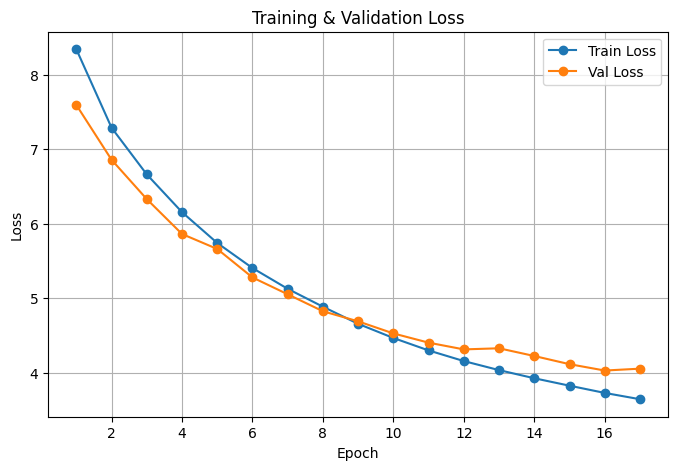

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(epochs[:len(val_loss)], train_loss[:len(val_loss)], label="Train Loss", marker='o')
plt.plot(epochs[:len(val_loss)], val_loss, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


Plotting the Top-1 accuracy curves

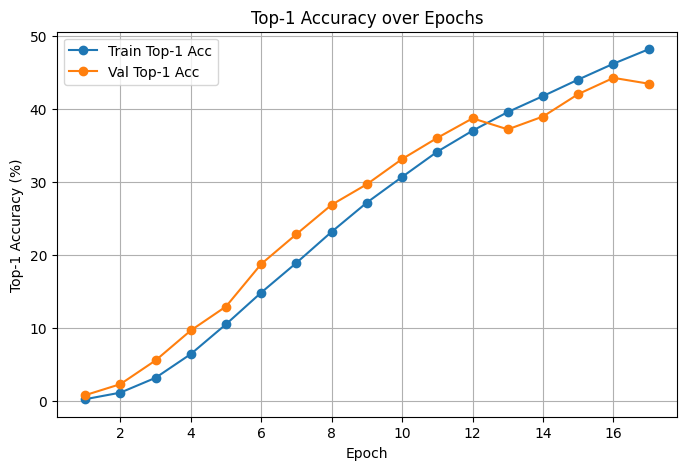

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(epochs[:len(val_top1)], train_top1, label="Train Top-1 Acc", marker='o')
plt.plot(epochs[:len(val_top1)], val_top1, label="Val Top-1 Acc", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Top-1 Accuracy (%)")
plt.title("Top-1 Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()


Plot Training and Validation Top-5 Accuracy

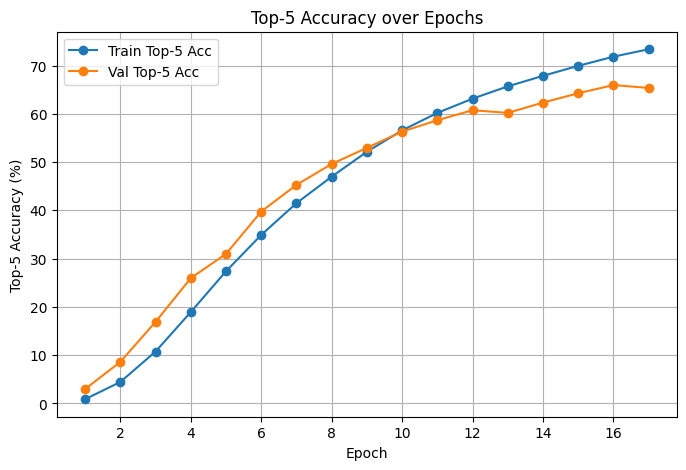

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(epochs[:len(val_top5)], train_top5, label="Train Top-5 Acc", marker='o')
plt.plot(epochs[:len(val_top5)], val_top5, label="Val Top-5 Acc", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Top-5 Accuracy (%)")
plt.title("Top-5 Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()


Evaluate the Model on Test Data

In [13]:
def evaluate(model, data_loader):
    # Set the model to evaluation mode
    model.eval()

    correct = 0  # Variable to store the number of correct predictions
    total = 0  # Variable to store the total number of predictions

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        # Iterate through the data loader for the test data
        for inputs, labels in data_loader:
            # Move the inputs and labels to the device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass: get model predictions
            outputs = model(inputs)

            # Get the predicted class by finding the class with the maximum score
            _, predicted = torch.max(outputs, 1)

            # Update total count of samples
            total += labels.size(0)

            # Update the count of correct predictions
            correct += (predicted == labels).sum().item()

    # Calculate the accuracy percentage
    return 100 * correct / total

# ==== Final Test Accuracy ====
# Calculate and print the test accuracy
test_accuracy = evaluate(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 47.73%


# Model no. 02 Resnet18

Load pretrained ResNet18

In [ ]:
model = models.resnet18(pretrained=True)

Unfreeze the last two layers for fine-tuning

In [ ]:
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

Modify final layer (add Dropout + classifier)

In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(num_ftrs, len(class_names))
)

Device setting

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda


Optimizer, Loss Function, Learning Rate Scheduler, and Early Stopping Configuration


In [ ]:
# Optimizer, Loss, Scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)
# Using Adam optimizer with weight decay (L2 regularization) to prevent overfitting.
# I only optimize parameters that require gradients (i.e., the unfrozen layers of the model).

criterion = nn.CrossEntropyLoss()
# CrossEntropyLoss is used for multi-class classification problems. It is appropriate since I am dealing with
# a classification task with more than two classes.

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)
# ReduceLROnPlateau adjusts the learning rate when the validation loss stops improving.
# It will reduce the learning rate by a factor of 0.5 if the validation loss does not improve for 2 epochs.

# Optional Early Stopping (manual logic)
best_val_loss = float('inf')
patience = 5
early_stop_counter = 0
# Early stopping is set up to halt training if the validation loss does not improve for 5 consecutive epochs.
# This helps to prevent overfitting by stopping the training when the model starts to overfit the training data.

# Training Loop
num_epochs = 20
# Set the total number of epochs for training.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Function to Calculate Top-1 and Top-5 Accuracy

In [ ]:
# Function to calculate Top-1 and Top-5 accuracy
def calculate_top_k_accuracy(outputs, labels, top_k=(1, 5)):
    # Get the top k predictions from the model outputs
    _, preds = torch.topk(outputs, max(top_k), 1, True, True)
    # Compare the top k predictions with the ground truth labels
    correct = preds.eq(labels.view(-1, 1).expand_as(preds))
    res = []
    for k in top_k:
        # Calculate the accuracy for each top_k value
        correct_k = correct[:, :k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / outputs.size(0)))
    return res


Set Output Directories for Training Logs and Checkpoints

In [ ]:
# Output paths
base_dir = "/kaggle/working"  # Base directory for storing outputs
log_dir = os.path.join(base_dir, "training_logs")  # Directory for storing training logs
checkpoint_dir = os.path.join(base_dir, "checkpoints_resnet")  # Directory for storing model checkpoints

# Create directories if they do not exist
os.makedirs(log_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)


Initialize metrics list for DataFrame logging

In [ ]:
metrics_log = []
best_val_loss = float("inf")
early_stop_counter = 0

Save Model Checkpoint Function

In [ ]:
def save_checkpoint(model, optimizer, epoch, val_loss, val_acc, train_loss, train_acc, filepath):
    # Create a dictionary to store model training information
    checkpoint = {
        'epoch': epoch,  # The current epoch
        'model_state_dict': model.state_dict(),  # The state dict of the model (model parameters)
        'optimizer_state_dict': optimizer.state_dict(),  # The state dict of the optimizer (optimizer parameters)
        'val_loss': val_loss,  # The validation loss at the current epoch
        'val_acc': val_acc,  # The validation accuracy at the current epoch
        'train_loss': train_loss,  # The training loss at the current epoch
        'train_acc': train_acc  # The training accuracy at the current epoch
    }

    # Save the checkpoint dictionary to a file
    torch.save(checkpoint, filepath)


Training Loop with Validation, Checkpoint Saving, and Early Stopping

In [ ]:
# Training loop for ResNet18
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    top1_acc = 0.0
    top5_acc = 0.0

    # Progress bar for training
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients of the optimizer
        outputs = model(inputs)  # Perform forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate the loss

        # Calculate Top-1 and Top-5 accuracy
        top1, top5 = calculate_top_k_accuracy(outputs, labels, top_k=(1, 5))
        top1_acc += top1.item()
        top5_acc += top5.item()

        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Count correct predictions

        # Update the progress bar with current loss and accuracy
        train_loader_tqdm.set_postfix(loss=loss.item(), acc=100 * correct / total)

    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_top1_acc = 0.0
    val_top5_acc = 0.0

    with torch.no_grad():  # Disable gradient computation during validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Perform forward pass
            loss = criterion(outputs, labels)  # Compute validation loss
            val_loss += loss.item()

            # Calculate Top-1 and Top-5 accuracy for validation
            top1, top5 = calculate_top_k_accuracy(outputs, labels, top_k=(1, 5))
            val_top1_acc += top1.item()
            val_top5_acc += top5.item()

            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()  # Count correct predictions

    # Compute average metrics
    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    avg_train_top1 = top1_acc / len(train_loader)
    avg_train_top5 = top5_acc / len(train_loader)
    avg_val_top1 = val_top1_acc / len(val_loader)
    avg_val_top5 = val_top5_acc / len(val_loader)

    # Logging the metrics for the current epoch
    log_data = {
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "train_acc": train_acc,
        "train_top1_acc": avg_train_top1,
        "train_top5_acc": avg_train_top5,
        "val_loss": avg_val_loss,
        "val_acc": val_acc,
        "val_top1_acc": avg_val_top1,
        "val_top5_acc": avg_val_top5
    }

    metrics_log.append(log_data)

    # Print metrics for the current epoch
    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Train Top-1 Acc: {avg_train_top1:.2f}% | Train Top-5 Acc: {avg_train_top5:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
          f"Val Top-1 Acc: {avg_val_top1:.2f}% | Val Top-5 Acc: {avg_val_top5:.2f}%")

    # Adjust learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Save checkpoint at the end of the epoch
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoints_resnet_epoch_{epoch+1}.pth")
    save_checkpoint(
        model,
        optimizer,
        epoch+1,
        avg_val_loss,
        val_acc,
        avg_train_loss,
        train_acc,
        checkpoint_path
    )

    print(f"[INFO] Checkpoint saved at {checkpoint_path}")

    # Early stopping mechanism to stop training if validation loss doesn't improve
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss  # Update the best validation loss
        early_stop_counter = 0  # Reset the early stopping counter
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:  # If no improvement after 'patience' epochs
            print("[EARLY STOPPING] No improvement in validation loss.")
            break


[Epoch 1] Train Loss: 7.3966 | Train Acc: 0.85% | Train Top-1 Acc: 0.85% | Train Top-5 Acc: 3.07% | Val Loss: 6.4425 | Val Acc: 2.79% | Val Top-1 Acc: 2.79% | Val Top-5 Acc: 8.77%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_1.pth


[Epoch 2] Train Loss: 5.9637 | Train Acc: 4.93% | Train Top-1 Acc: 4.93% | Train Top-5 Acc: 14.28% | Val Loss: 5.3819 | Val Acc: 9.41% | Val Top-1 Acc: 9.40% | Val Top-5 Acc: 23.32%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_2.pth


[Epoch 3] Train Loss: 5.0160 | Train Acc: 11.74% | Train Top-1 Acc: 11.74% | Train Top-5 Acc: 28.19% | Val Loss: 4.7144 | Val Acc: 16.01% | Val Top-1 Acc: 16.01% | Val Top-5 Acc: 34.26%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_3.pth


[Epoch 4] Train Loss: 4.2780 | Train Acc: 19.94% | Train Top-1 Acc: 19.94% | Train Top-5 Acc: 41.38% | Val Loss: 4.1882 | Val Acc: 22.46% | Val Top-1 Acc: 22.45% | Val Top-5 Acc: 43.74%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_4.pth


[Epoch 5] Train Loss: 3.7107 | Train Acc: 27.56% | Train Top-1 Acc: 27.56% | Train Top-5 Acc: 51.45% | Val Loss: 3.9017 | Val Acc: 26.99% | Val Top-1 Acc: 26.99% | Val Top-5 Acc: 49.12%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_5.pth


[Epoch 6] Train Loss: 3.2911 | Train Acc: 34.19% | Train Top-1 Acc: 34.19% | Train Top-5 Acc: 58.79% | Val Loss: 3.6276 | Val Acc: 32.41% | Val Top-1 Acc: 32.40% | Val Top-5 Acc: 54.03%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_6.pth


[Epoch 7] Train Loss: 2.9500 | Train Acc: 39.42% | Train Top-1 Acc: 39.42% | Train Top-5 Acc: 64.68% | Val Loss: 3.4859 | Val Acc: 34.72% | Val Top-1 Acc: 34.72% | Val Top-5 Acc: 56.97%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_7.pth


[Epoch 8] Train Loss: 2.6624 | Train Acc: 44.32% | Train Top-1 Acc: 44.32% | Train Top-5 Acc: 69.23% | Val Loss: 3.4106 | Val Acc: 36.19% | Val Top-1 Acc: 36.18% | Val Top-5 Acc: 58.05%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_8.pth


[Epoch 9] Train Loss: 2.4291 | Train Acc: 48.76% | Train Top-1 Acc: 48.76% | Train Top-5 Acc: 72.98% | Val Loss: 3.3433 | Val Acc: 37.34% | Val Top-1 Acc: 37.32% | Val Top-5 Acc: 59.04%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_9.pth


[Epoch 10] Train Loss: 2.2417 | Train Acc: 52.04% | Train Top-1 Acc: 52.04% | Train Top-5 Acc: 75.97% | Val Loss: 3.2578 | Val Acc: 39.43% | Val Top-1 Acc: 39.43% | Val Top-5 Acc: 60.37%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_10.pth


[Epoch 11] Train Loss: 2.0783 | Train Acc: 54.86% | Train Top-1 Acc: 54.86% | Train Top-5 Acc: 78.45% | Val Loss: 3.1952 | Val Acc: 40.36% | Val Top-1 Acc: 40.35% | Val Top-5 Acc: 62.24%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_11.pth


[Epoch 12] Train Loss: 1.9519 | Train Acc: 57.24% | Train Top-1 Acc: 57.24% | Train Top-5 Acc: 80.10% | Val Loss: 3.2194 | Val Acc: 40.47% | Val Top-1 Acc: 40.46% | Val Top-5 Acc: 61.70%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_12.pth


[Epoch 13] Train Loss: 1.8411 | Train Acc: 59.06% | Train Top-1 Acc: 59.06% | Train Top-5 Acc: 81.87% | Val Loss: 3.1501 | Val Acc: 41.61% | Val Top-1 Acc: 41.60% | Val Top-5 Acc: 62.63%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_13.pth


[Epoch 14] Train Loss: 1.7418 | Train Acc: 61.17% | Train Top-1 Acc: 61.17% | Train Top-5 Acc: 83.23% | Val Loss: 3.1507 | Val Acc: 42.57% | Val Top-1 Acc: 42.56% | Val Top-5 Acc: 62.78%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_14.pth


[Epoch 15] Train Loss: 1.6546 | Train Acc: 62.90% | Train Top-1 Acc: 62.90% | Train Top-5 Acc: 84.50% | Val Loss: 3.0848 | Val Acc: 43.49% | Val Top-1 Acc: 43.49% | Val Top-5 Acc: 63.96%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_15.pth


[Epoch 16] Train Loss: 1.5965 | Train Acc: 63.99% | Train Top-1 Acc: 63.99% | Train Top-5 Acc: 85.35% | Val Loss: 3.1012 | Val Acc: 43.14% | Val Top-1 Acc: 43.14% | Val Top-5 Acc: 64.11%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_16.pth


[Epoch 17] Train Loss: 1.5302 | Train Acc: 65.24% | Train Top-1 Acc: 65.24% | Train Top-5 Acc: 86.06% | Val Loss: 3.1040 | Val Acc: 43.69% | Val Top-1 Acc: 43.69% | Val Top-5 Acc: 64.22%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_17.pth


[Epoch 18] Train Loss: 1.4756 | Train Acc: 66.25% | Train Top-1 Acc: 66.25% | Train Top-5 Acc: 86.87% | Val Loss: 3.1393 | Val Acc: 43.34% | Val Top-1 Acc: 43.33% | Val Top-5 Acc: 63.67%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_18.pth


[Epoch 19] Train Loss: 0.9157 | Train Acc: 80.13% | Train Top-1 Acc: 80.13% | Train Top-5 Acc: 93.54% | Val Loss: 2.8129 | Val Acc: 49.57% | Val Top-1 Acc: 49.57% | Val Top-5 Acc: 68.38%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_19.pth


[Epoch 20] Train Loss: 0.8230 | Train Acc: 82.33% | Train Top-1 Acc: 82.33% | Train Top-5 Acc: 94.72% | Val Loss: 2.8724 | Val Acc: 49.01% | Val Top-1 Acc: 49.01% | Val Top-5 Acc: 67.60%
[INFO] Checkpoint saved at /kaggle/working/checkpoints_resnet/checkpoints_resnet_epoch_20.pth


Save log as CSV for plotting

In [ ]:
metrics_df = pd.DataFrame(metrics_log)
metrics_df.to_csv(os.path.join(log_dir, "resnet_metrics.csv"), index=False)

Load metrics

In [ ]:
df = pd.read_csv("/kaggle/working/training_logs/resnet_metrics.csv")

Training & Validation Loss

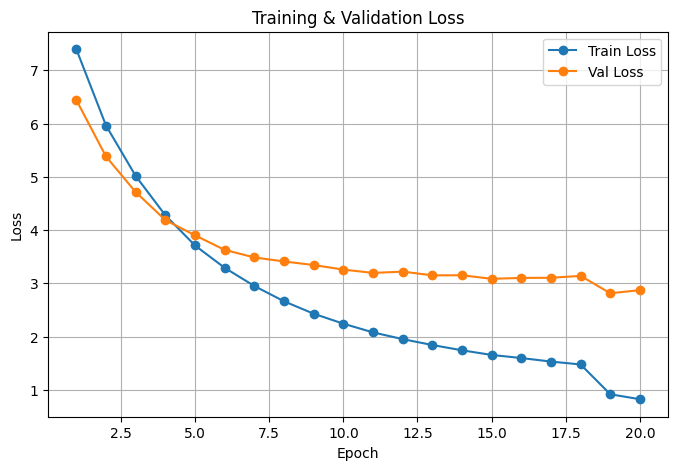

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Train Loss", marker='o')
plt.plot(epochs, val_loss, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


Top-1 Accuracy

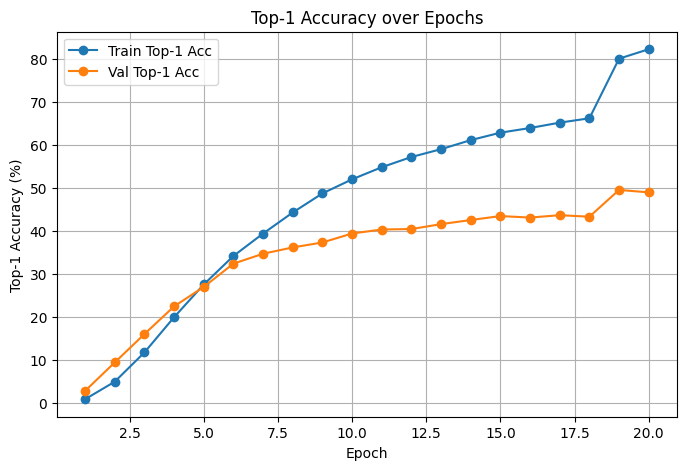

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_top1, label="Train Top-1 Acc", marker='o')
plt.plot(epochs, val_top1, label="Val Top-1 Acc", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Top-1 Accuracy (%)")
plt.title("Top-1 Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()


Top-5 Accuracy

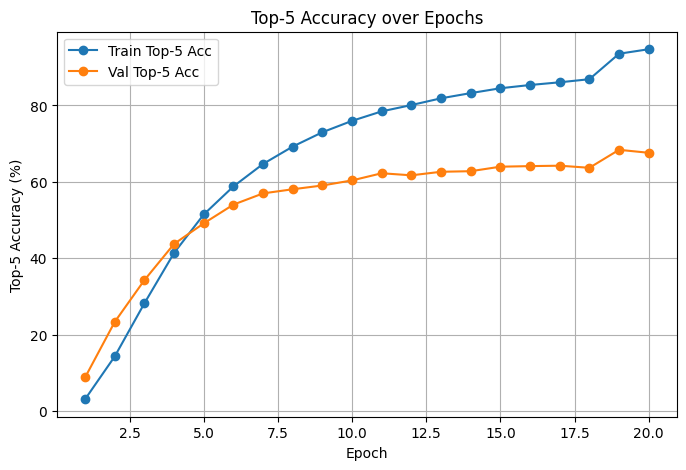

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_top5, label="Train Top-5 Acc", marker='o')
plt.plot(epochs, val_top5, label="Val Top-5 Acc", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Top-5 Accuracy (%)")
plt.title("Top-5 Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()


Final Test Accuracy

In [23]:
def evaluate(model, data_loader):
    # Set the model to evaluation mode
    model.eval()

    correct = 0  # Variable to store the number of correct predictions
    total = 0  # Variable to store the total number of predictions

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        # Iterate through the data loader for the test data
        for inputs, labels in data_loader:
            # Move the inputs and labels to the device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass: get model predictions
            outputs = model(inputs)

            # Get the predicted class by finding the class with the maximum score
            _, predicted = torch.max(outputs, 1)

            # Update total count of samples
            total += labels.size(0)

            # Update the count of correct predictions
            correct += (predicted == labels).sum().item()

    # Calculate the accuracy percentage
    return 100 * correct / total

# Calculate and print the test accuracy
test_accuracy = evaluate(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 80.73%


### Experiment with different combinations

Load pretrained ResNet50

In [ ]:
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s] 


In [ ]:
# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer4 and fc for fine-tuning
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

Modify classifier head

In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.LeakyReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(class_names))
)


Move model to device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Optimizer, Loss, Scheduler

In [ ]:
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Setting Directories

In [ ]:
base_dir = "/kaggle/working"
log_dir = os.path.join(base_dir, "training_logs_task2")
checkpoint_dir = os.path.join(base_dir, "checkpoints_task2")
os.makedirs(log_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

Training Configration

In [ ]:
num_epochs = 15
patience = 5
best_val_loss = float("inf")
early_stop_counter = 0
metrics_log = []

In [ ]:
def save_checkpoint(model, optimizer, epoch, val_loss, val_acc, train_loss, train_acc, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss,
        'val_acc': val_acc,
        'train_loss': train_loss,
        'train_acc': train_acc
    }
    torch.save(checkpoint, filepath)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    top1_acc = 0.0
    top5_acc = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        top1, top5 = calculate_top_k_accuracy(outputs, labels, top_k=(1, 5))
        top1_acc += top1.item()
        top5_acc += top5.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_loader_tqdm.set_postfix(loss=loss.item(), acc=100 * correct / total)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_top1_acc = 0.0
    val_top5_acc = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            top1, top5 = calculate_top_k_accuracy(outputs, labels, top_k=(1, 5))
            val_top1_acc += top1.item()
            val_top5_acc += top5.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Averages
    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    avg_train_top1 = top1_acc / len(train_loader)
    avg_train_top5 = top5_acc / len(train_loader)
    avg_val_top1 = val_top1_acc / len(val_loader)
    avg_val_top5 = val_top5_acc / len(val_loader)

    log_data = {
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "train_acc": train_acc,
        "train_top1_acc": avg_train_top1,
        "train_top5_acc": avg_train_top5,
        "val_loss": avg_val_loss,
        "val_acc": val_acc,
        "val_top1_acc": avg_val_top1,
        "val_top5_acc": avg_val_top5
    }
    metrics_log.append(log_data)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
          f"Top1: {avg_val_top1:.2f}% | Top5: {avg_val_top5:.2f}%")

    # Scheduler step
    scheduler.step(avg_val_loss)

    # Save checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
    save_checkpoint(model, optimizer, epoch+1, avg_val_loss, val_acc, avg_train_loss, train_acc, checkpoint_path)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("[EARLY STOPPING] No improvement in validation loss.")
            break

# Save all metrics to CSV
df = pd.DataFrame(metrics_log)
df.to_csv(os.path.join(log_dir, "metrics.csv"), index=False)

[Epoch 1] Train Loss: 8.3641 | Train Acc: 0.15% | Val Loss: 7.2159 | Val Acc: 0.77% | Top1: 0.77% | Top5: 3.01%


[Epoch 2] Train Loss: 6.6144 | Train Acc: 2.38% | Val Loss: 5.7213 | Val Acc: 6.61% | Top1: 6.61% | Top5: 18.71%


[Epoch 3] Train Loss: 5.3306 | Train Acc: 8.69% | Val Loss: 4.7948 | Val Acc: 16.57% | Top1: 16.57% | Top5: 34.64%


[Epoch 4] Train Loss: 4.2989 | Train Acc: 18.80% | Val Loss: 4.2073 | Val Acc: 24.62% | Top1: 24.62% | Top5: 44.64%


[Epoch 5] Train Loss: 3.3970 | Train Acc: 30.72% | Val Loss: 3.7376 | Val Acc: 31.60% | Top1: 31.60% | Top5: 52.90%


[Epoch 6] Train Loss: 2.5993 | Train Acc: 43.54% | Val Loss: 3.5527 | Val Acc: 36.46% | Top1: 36.46% | Top5: 56.59%


[Epoch 7] Train Loss: 1.9472 | Train Acc: 55.14% | Val Loss: 3.4938 | Val Acc: 39.15% | Top1: 39.16% | Top5: 58.57%


[Epoch 8] Train Loss: 1.4232 | Train Acc: 65.61% | Val Loss: 3.6386 | Val Acc: 40.22% | Top1: 40.23% | Top5: 59.97%


[Epoch 9] Train Loss: 1.0413 | Train Acc: 73.82% | Val Loss: 3.8479 | Val Acc: 40.50% | Top1: 40.50% | Top5: 59.67%


[Epoch 10] Train Loss: 0.7907 | Train Acc: 79.16% | Val Loss: 3.8470 | Val Acc: 42.38% | Top1: 42.38% | Top5: 61.48%


[Epoch 11] Train Loss: 0.4349 | Train Acc: 88.40% | Val Loss: 3.8204 | Val Acc: 44.06% | Top1: 44.06% | Top5: 62.82%


[Epoch 12] Train Loss: 0.3028 | Train Acc: 91.91% | Val Loss: 3.9937 | Val Acc: 43.52% | Top1: 43.52% | Top5: 62.19%
[EARLY STOPPING] No improvement in validation loss.


Training & Validation Loss

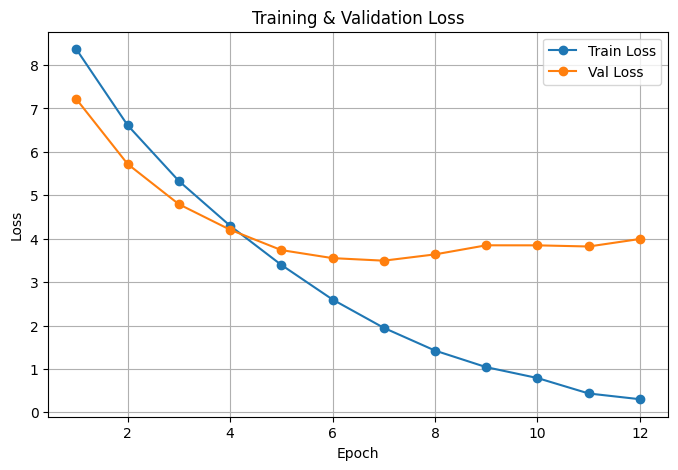

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Train Loss", marker='o')
plt.plot(epochs, val_loss, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


Top-1 Accuracy

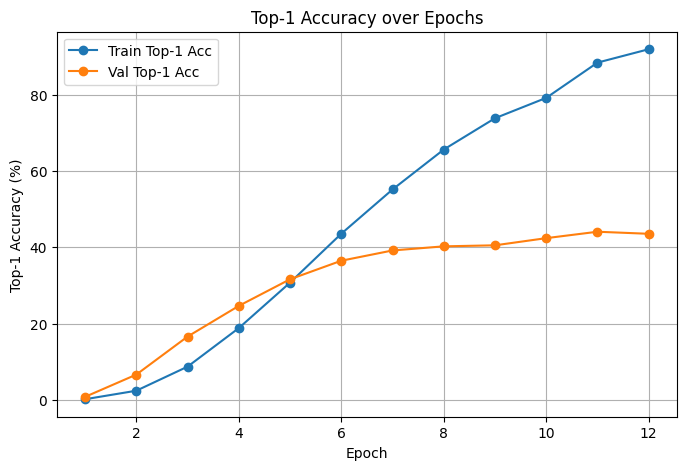

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_top1, label="Train Top-1 Acc", marker='o')
plt.plot(epochs, val_top1, label="Val Top-1 Acc", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Top-1 Accuracy (%)")
plt.title("Top-1 Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()


Top-5 Accuracy

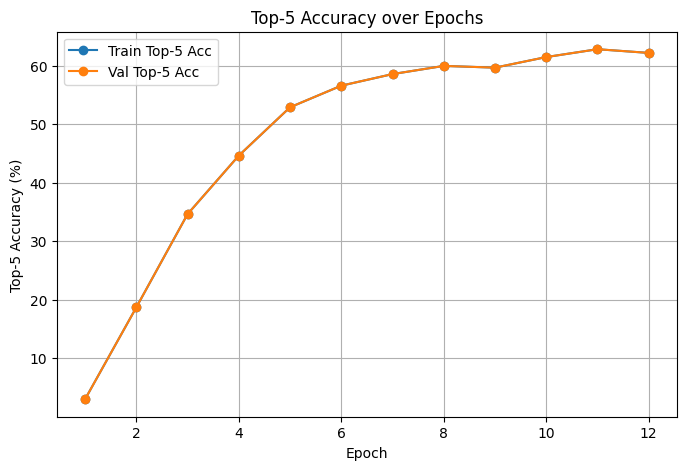

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_top5, label="Train Top-5 Acc", marker='o')
plt.plot(epochs, val_top5, label="Val Top-5 Acc", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Top-5 Accuracy (%)")
plt.title("Top-5 Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()
